# Test outputting the light curves

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import csv
import os
import pandas as pd
import pickle

import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from OpSim import OpSim
from newLSSTEBWorker import LSSTEBWorker 

from matplotlib import pyplot as plt
#%matplotlib notebook
%matplotlib inline

# this is horribly slow
# %load_ext autoreload
# %autoreload 2

/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2286: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


## Pick an OpSim field

In [2]:
filters = ['u_', 'g_', 'r_', 'i_', 'z_', 'y_']

In [3]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/baseline2018a.db'
OpS.getAllOpSimFields()

getting OpSim fields...
have summary cursor.
have field cursor.
returned 5292 fields


914.0


/Users/ageller/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:414: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


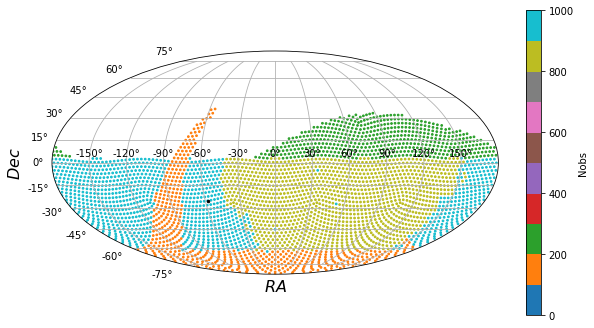

In [4]:
coords = SkyCoord(OpS.RA, OpS.Dec, unit=(u.degree, u.degree),frame='icrs')
lGal = coords.galactic.l.wrap_at(180.*u.degree).degree
bGal = coords.galactic.b.wrap_at(180.*u.degree).degree

raGal = coords.icrs.ra.wrap_at(180.*u.degree).degree
decGal = coords.icrs.dec.wrap_at(180.*u.degree).degree


f, ax = plt.subplots(subplot_kw={'projection': "mollweide"}, figsize=(10,8))
ax.grid(True)
ax.set_xlabel(r"$RA$",fontsize=16)
ax.set_ylabel(r"$Dec$",fontsize=16)
xx = np.where(OpS.Nobs > 0)
mlw = ax.scatter(raGal[xx]*np.pi/180.,decGal[xx]*np.pi/180., s = 3, c=OpS.Nobs[xx], cmap='tab10', alpha = 1, vmin=0, vmax=1000)
cbar = f.colorbar(mlw, shrink=0.7)
cbar.set_label(r'Nobs')
    
#choose some number
OpSimi = 1520
print(OpS.Nobs[OpSimi])
ax.scatter([raGal[OpSimi]*np.pi/180.],[decGal[OpSimi]*np.pi/180.], s = 6, c='black')


In [5]:
OpS.setDates(OpSimi, filters)

*The stuff above takes a while to run because of getting OpSim.*

## Set up the worker and get the Galaxy model

In [6]:
worker = LSSTEBWorker()
worker.OpSim = OpS
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
#worker.initialize(OpSimi) #this just sets the dates, but I already did that above

In [7]:
galDir = 'grid'
if not os.path.exists(galDir):
    os.makedirs(galDir)
worker.galDir = galDir
worker.getGalaxy(OpSimi, deleteModel = False, downloadModel = False) #already downloaded this one

downloaded TRILEGAL model for ID=1521.0, RA=302.03318, DEC=-25.29462, Nstars=377029.0, Nstars/resEl=0.0005937090576971529


In [8]:
print(worker.Galaxy.model.sample())

       Gc  logAge  [M/H]    m_ini   logL  logTe   logg  m-M0     Av  m2/m1  \
36001   3   10.07  -1.11  0.62579 -0.688  3.709  4.703  16.7  0.364    0.0   

        mbol   u_mag   g_mag   r_mag   i_mag   z_mag   Y_mag   Mact  logDist  
36001  23.19  25.742  24.186  23.493  23.214  23.073  22.994  0.626     1.34  


### Set up the output file

In [9]:
def writeLine(csvwriter, EB, LCfile):
    output = [EB.period, EB.m1, EB.m2, EB.r1, EB.r2, EB.eccentricity, EB.inclination, EB.dist, EB.nobs, 
              EB.AV, EB.M_H, EB.appMagMean['r_'], EB.maxDeltaMag, EB.deltaMag['r_'], EB.eclipseDepthFrac,
              EB.appmag_failed, EB.incl_failed, EB.period_failed, EB.radius_failed, EB.eclipseDepth_failed]
    
    #this is for gatspy
    for filt in filters:
        output.append(EB.LSS[filt]) 
    output.append(EB.LSM) 
    output.append(LCfile)
        
    csvwriter.writerow(output)

## Sample from the galaxy to get the binaries

In [ ]:
#open the file and write the header
summaryFile = 'LC/summary_OpSim' + str(OpSimi).zfill(4) + '.csv'
csvfile = open(summaryFile, 'w')
csvwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
cols = ['p', 'm1', 'm2', 'r1', 'r2', 'e', 'i', 'd', 'nobs',
        'Av','[M/H]','appMagMean_r', 'maxDeltaMag', 'deltaMag_r','eclipseDepthFrac_r',
        'mag_failure', 'incl_failure', 'period_failure', 'radius_failure', 'eclipseDepth_failure',
        'u_LSS_PERIOD', 'g_LSS_PERIOD', 'r_LSS_PERIOD', 'i_LSS_PERIOD', 'z_LSS_PERIOD', 'y_LSS_PERIOD', 'LSM_PERIOD',
        'LC_file']
csvwriter.writerow(cols)    


nOut = 10 #number of EBs that I want to output
nFinished = 0

worker.magLims = [15.8, 19.5] #prsa limits
worker.eclipseDepthLim = 1. #depth / error
    
while nFinished < nOut:
    s = worker.Galaxy.model.sample()
    binary = worker.makeBinaryFromGalaxy(s)
    line = np.array([binary['m1'], 
            binary['m2'],
            binary['logp'],
            binary['ecc'],
            binary['rad1'],
            binary['rad2'],
            binary['lum1'],
            binary['lum2'], 
            0, 0, 0, 
            binary['dist'],
            binary['inc'],
            binary['OMEGA'],
            binary['omega'],
            binary['Av'],
            binary['MH'],
            binary['teff1'],
            binary['teff2'],
            binary['logg1'],
            binary['logg2'],
            binary['rmag']])

    worker.getEB(line, OpSimi=OpSimi)
    fname = None
    if (worker.EB.observable):
        worker.run_ellc(0) 
        print('observable in mag', worker.EB.eclipseDepthFrac)
        if (worker.EB.observable):
            print('observable in eclipse')
            worker.run_gatspy(0)
            fname = 'LC/ellc_OpSim' + str(OpSimi).zfill(4) + '_' + str(nFinished).zfill(4)+'.pickle'
            worker.EB.outputLCtoFile(fname)
            nFinished += 1
    writeLine(csvwriter, worker.EB, fname)
    
csvfile.close()

observable in mag 16.242604383463934
observable in eclipse 16.242604383463934


## Test the output files

In [ ]:
summary = pd.read_csv(summaryFile)
summary

In [ ]:
f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
_ = ax1.hist(np.log10(summary['p']))
ax1.set_xlabel('log(p)')

_ = ax2.hist(summary['e'])
ax2.set_xlabel('ecc')

_ = ax3.hist(summary['m2']/summary['m1'])
ax3.set_xlabel('q')

In [ ]:
for index, row in summary.iterrows():
    if (not pd.isna(row['LC_file'])):
        #print(row)
        key = 'LSM_PERIOD'
        fullP = abs(row[key] - row['p'])/row['p']
        halfP = abs(row[key] - 0.5*row['p'])/(0.5*row['p'])
        twiceP = abs(row[key] - 2.*row['p'])/(2.*row['p'])
        print(row['p'], fullP, halfP, twiceP)
        
        file = open(row['LC_file'], 'rb')
        lc = pickle.load(file)
        file.close()
        fig,ax = plt.subplots(6,1, figsize=(6,8), sharex = True)
        for i,f in enumerate(filters):
            ax[i].plot((lc[f]['OpSimDates'] % row['p']), lc[f]['mag'],'.', color='red')
            ax[i].plot((lc[f]['OpSimDates'] % row['p']), lc[f]['magObs'],'.', alpha=0.3, color='blue')
            ax[i].set_ylim(max(lc[f]['magObs']), min(lc[f]['magObs']))
            ax[i].set_ylabel(f)
        